# Aircraft Configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [1]:
import numpy as np
import pydot
from airconics.topology import Topology_GPTools

from IPython.display import Image, display

In [2]:
topo_tools = Topology_GPTools()
# Try to compile a single individual and visualise both the tree and geometry
config = topo_tools.randomize()

print(config)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config.Display(renderer)

renderer

mirror2(fuselage0(rand(), rand(), rand(), rand(), rand(), rand(), rand()), mirror2(mirror1(liftingsurface1(0.6973470650360185, 0.5466782790953331, 0.00040076410993750144, 0.472973292852341, 0.48470734478194033, 0.4873948143896042, AirlinerFin, empty)), fuselage0(rand(), rand(), rand(), rand(), rand(), rand(), rand())))


<TornadoWebRenderer at http://PChambers_ngcm:42661/get/eaaa387147554190994461ea7e861e7b>

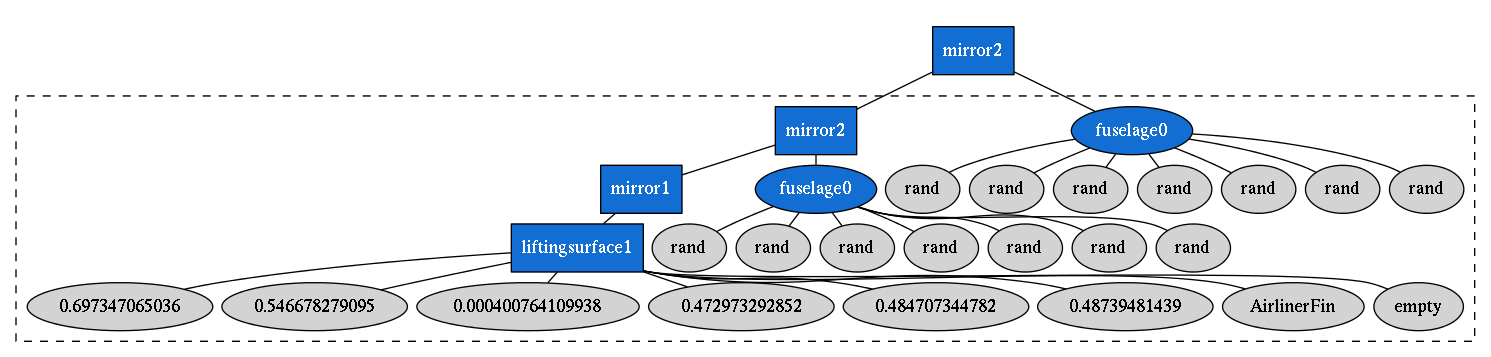

In [3]:
Image(config.pydot_graph().create_png())

In [4]:
expr_string = """fuselage1(0., 0., 0., 1.0, 0.182, 0.293, 0.5, mirror2(
    liftingsurface0(0., 0., 0., 1., 0.68, 0., AirlinerTP),
    liftingsurface0(0.55, 0., 0., 1., 0.5, 0.28, AirlinerFin)))"""
config2 = topo_tools.from_string(expr_string)

print(config2)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config2.Display(renderer)

renderer



fuselage1(0.0, 0.0, 0.0, 1.0, 0.182, 0.293, 0.5, mirror2(liftingsurface0(0.0, 0.0, 0.0, 1.0, 0.68, 0.0, AirlinerTP), liftingsurface0(0.55, 0.0, 0.0, 1.0, 0.5, 0.28, AirlinerFin)))


<TornadoWebRenderer at http://PChambers_ngcm:43547/get/ec2c936847c242abb813cecbe89a701a>

In [5]:
# config2.Write('GP_output.step')
graph = config2.pydot_graph()
Image(graph.create_png())

repr(config2._deap_tree)

'[<deap.gp.Primitive object at 0x7f026434cfc8>, <deap.gp.Terminal object at 0x7f026125feb0>, <deap.gp.Terminal object at 0x7f026125fe60>, <deap.gp.Terminal object at 0x7f026125fe10>, <deap.gp.Terminal object at 0x7f026125fdc0>, <deap.gp.Terminal object at 0x7f026125fd70>, <deap.gp.Terminal object at 0x7f026125fbe0>, <deap.gp.Terminal object at 0x7f026125fd20>, <deap.gp.Primitive object at 0x7f0263eb9158>, <deap.gp.Primitive object at 0x7f026434cec0>, <deap.gp.Terminal object at 0x7f0260cd5050>, <deap.gp.Terminal object at 0x7f0260cd50a0>, <deap.gp.Terminal object at 0x7f0260cd50f0>, <deap.gp.Terminal object at 0x7f0260cd5140>, <deap.gp.Terminal object at 0x7f0260cd5190>, <deap.gp.Terminal object at 0x7f0260cd51e0>, <deap.gp.Terminal object at 0x7f0264351730>, <deap.gp.Primitive object at 0x7f026434cec0>, <deap.gp.Terminal object at 0x7f0260cd5230>, <deap.gp.Terminal object at 0x7f0260cd5280>, <deap.gp.Terminal object at 0x7f0260cd52d0>, <deap.gp.Terminal object at 0x7f0260cd5320>, <dea

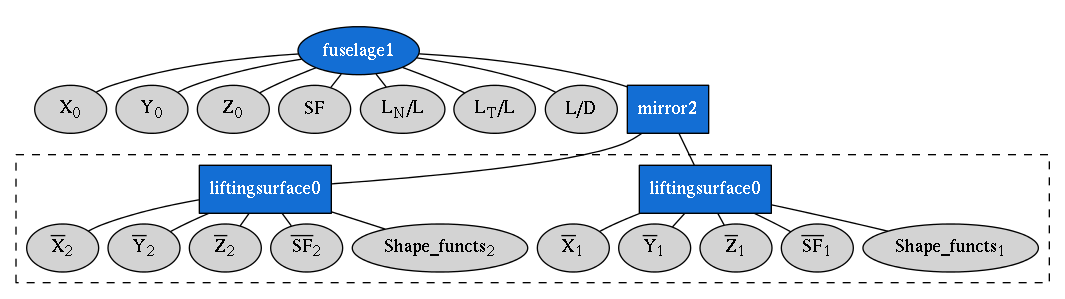

In [6]:
# For now, I'll have to do this by hand...
graph = """digraph G {
ranksep="0.1";
nodesep="0.1";
# splines=ortho;
node [style=filled];
edge [arrowhead=none];
subgraph cluster_standard {
color=invis;
0 [shape=ellipse, fillcolor="#136ed4", label=fuselage1, fontcolor="white"];
1 [shape=ellipse, label=<X<SUB>0</SUB>>];
2 [shape=ellipse, label=<Y<SUB>0</SUB>>];
3 [shape=ellipse, label=<Z<SUB>0</SUB>>];
4 [shape=ellipse, label=<SF>];
5 [shape=ellipse, label=<L<SUB>N</SUB>/L>];
6 [shape=ellipse, label=<L<SUB>T</SUB>/L>];
7 [shape=ellipse, label="L/D"];
8 [shape=box, fillcolor="#136ed4", label="mirror2", fontcolor="white"];
}

subgraph cluster_mirrored {
style=dashed;
9 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
10 [shape=ellipse, label=<<O>X</O><SUB>1</SUB>>];
11 [shape=ellipse, label=<<O>Y</O><SUB>1</SUB>>];
12 [shape=ellipse, label=<<O>Z</O><SUB>1</SUB>>];
13 [shape=ellipse, label=<<O>SF</O><SUB>1</SUB>>];
20 [shape=ellipse, label=<Shape_functs<SUB>1</SUB>>];

rank=same;
14 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
15 [shape=ellipse, label=<<O>X</O><SUB>2</SUB>>];
16 [shape=ellipse, label=<<O>Y</O><SUB>2</SUB>>];
17 [shape=ellipse, label=<<O>Z</O><SUB>2</SUB>>];
18 [shape=ellipse, label=<<O>SF</O><SUB>2</SUB>>];
21 [shape=ellipse, label=<Shape_functs<SUB>2</SUB>>];
}

0 -> 8;
8-> 9;
8 -> 14;

0 -> 1;
0 -> 2;
0 -> 3;
0 -> 4;
0 -> 5;
0 -> 6;
0 -> 7;
# 0 -> 9;
# 0 -> 14;
9 -> 10;
9 -> 11;
9 -> 12;
9 -> 13;
9-> 20;
14 -> 15;
14 -> 16;
14 -> 17;
14 -> 18;
14->21;
}
"""
dotgraph = pydot.graph_from_dot_data(graph)
# dotgraph.write_svg('/home/pchambers/Documents/PhD/SABTalk_2017/images/tree1.svg')
Image(dotgraph.create_png())

In [7]:
# dotgraph.write_pdf('/home/pchambers/Documents/PhD/Aviation2017/aviation_2017_paper/figure/gplayout_tree2.pdf')

## Conventional Airliner

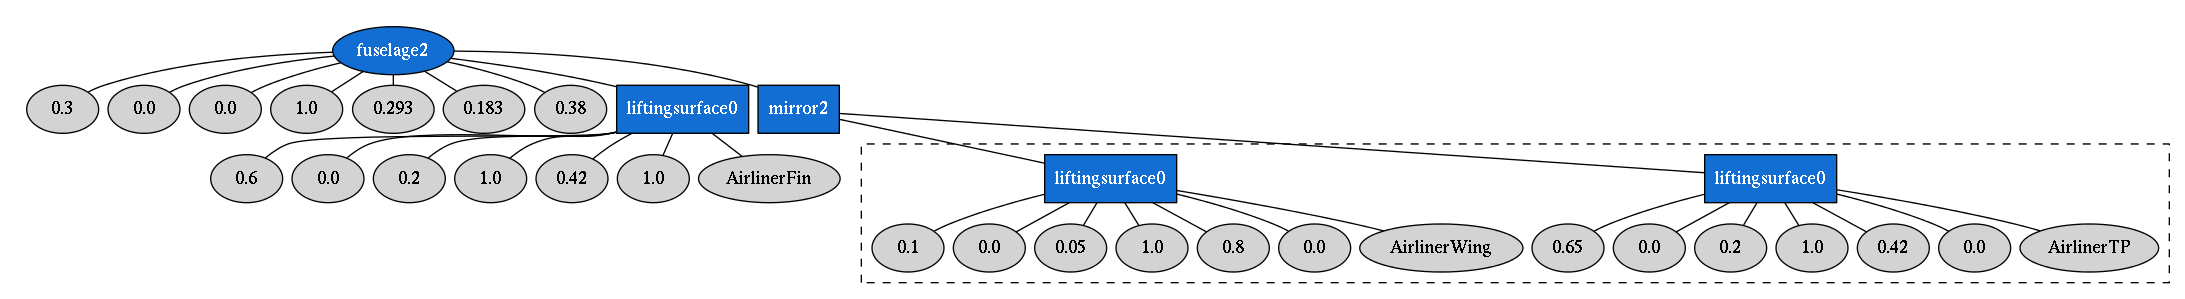

<TornadoWebRenderer at http://PChambers_ngcm:36158/get/4e2664ca30244c1e9a3d5b8e00d6d228>

In [8]:
expr_string = """fuselage2(0.3, 0., 0., 1., 0.293, 0.183, 0.38, 
            liftingsurface0(0.6, 0., 0.2, 1., 0.42, 1.0, AirlinerFin) mirror2(
                liftingsurface0(0.65, 0., 0.2, 1., 0.42, 0., AirlinerTP), liftingsurface0( 0.1, 0., 0.05, 1., 0.8, 0., AirlinerWing)))"""

topo = topo_tools.from_string(expr_string)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

## General Atomics MQ-1 Predator

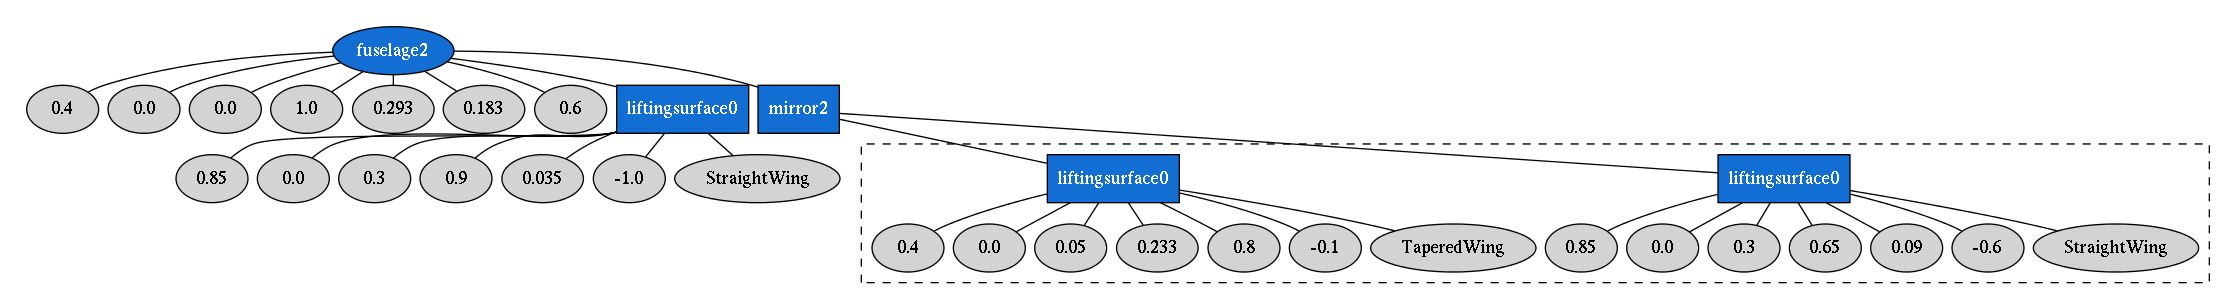

<TornadoWebRenderer at http://PChambers_ngcm:33415/get/ef45300d6f5f47bbafb33ee716c523cc>

In [9]:
# Need to extend the maximum number of attachments for the predator:
topo_tools = Topology_GPTools(MaxAttachments=4)

expr_string = """fuselage2(0.4, 0., 0., 1., 0.293, 0.183, 0.6, 
            liftingsurface0(0.85, 0., 0.3, 0.9, 0.035, -1.0, StraightWing) mirror2(
                liftingsurface0(0.85, 0., 0.3, 0.65, 0.09, -0.6, StraightWing), liftingsurface0(0.4, 0., 0.05, 0.233, 0.8, -0.1, TaperedWing)))"""

topo = topo_tools.from_string(expr_string)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

### From JSON

User defined JSON files can be used to create new component hierarchies using the `Topology_GPTools.from_JSONFile` method. This offers an interface for describing topologies that is human-readable.

The format See the [presets directory]() on github for examples - we'll use the predator example below for demonstration

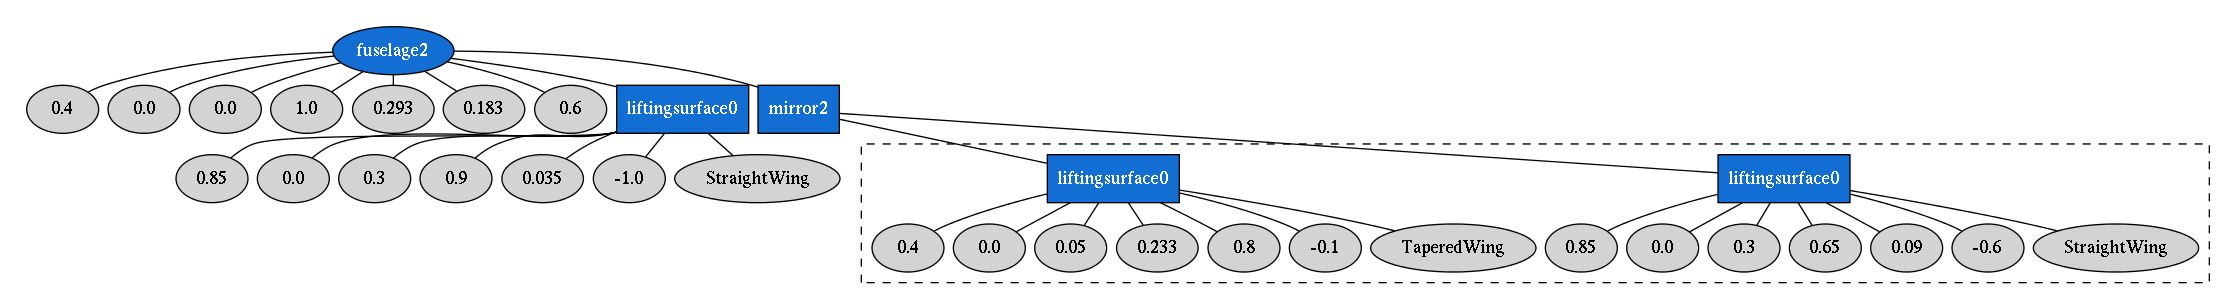

<TornadoWebRenderer at http://PChambers_ngcm:46506/get/a4fefe5bbb3b41189b64472574f18018>

In [20]:
import os, airconics

topo_tools = Topology_GPTools(MaxAttachments=4)

fname = os.path.join(os.path.dirname(airconics.__file__),
            os.path.abspath('resources/configuration_app/presets/predator.json'))

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

## Optimisation

**Note**: The optimisation setup code provided here is already included in the `Topology_GPTools` class, and can be used as default via the `Topology_GPTools.optimize` method. It is included here for those interested in how the evolutionary algorithm operates.

### The Objective Function

User-defined functions for the topology optimisation are catered for in the `Topology_GPTools` class. The function should take in a `Topology` (See: `airconics.topology.Topology`), and return a single number: default behaviour is that this measure of fitness will be maximised, i.e., topologies with a greater value 

In [12]:
def default_fitness(topology):
    """The default fitness function used by the Topology class

    Parameters
    ----------
    topology - Topology object
        The topology containing the geometry and component hierarchy
        information for which to calculate the 'current' fitness

    Notes
    -----
    Until I come with a better fitness function, this fitness function simply
    tries to maximise the volume of the bounding box
    """
    xmin, ymin, zmin, xmax, ymax, zmax = topology.Extents()
    return (xmax - xmin) * (ymax - ymin) * (zmax - zmin)

# Could use an existing topology, like the predator drone above, to test the function:
print(default_fitness(topo))

40.0548776626


### Evolution Setup

In [13]:
from deap import tools, gp, algorithms

topo_tools = Topology_GPTools(MaxAttachments=4, fitness_funct=default_fitness)

# This is a duplicate of the code included in topo_tools.create_toolbox, for illustration:
# The evolutionary operators
topo_tools._toolbox.register("evaluate", topo_tools.evalTopology)
topo_tools._toolbox.register("select", tools.selTournament, tournsize=2)
topo_tools._toolbox.register("mate", gp.cxOnePoint)
topo_tools._toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
topo_tools._toolbox.register("mutate", gp.mutUniform,
                 expr=topo_tools._toolbox.expr_mut, pset=topo_tools._pset)

# This is a duplicate of the code in topo_tools.optimize
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
hof = tools.HallOfFame(1)

# This is small in GP, but this is used for demonstration purposes.
# Larger scale simulations should have a much larger population.
popsize = 10

population = topo_tools._toolbox.population(popsize)

# This is commented out to save reset time of this notebook during development
# algorithms.eaSimple(population, topo_tools._toolbox, 0.5, 0.2,
#                     20, stats, halloffame=hof)

# # get the best individual and rerun it:
# best = hof[0]
# best_topology = topo_tools.run(best)

# renderer = TornadoWebRenderer()

# best_topology.Display(renderer)

# renderer

In [14]:
i = topo_tools._toolbox.individual()

In [15]:
i.fitness

deap.creator.FitnessMax(())